# Pyomo.DoE: Exploratory Analysis

In [1]:
import sys

# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import (
    TCLabExperiment,
    create_model,
    extract_results,
    extract_plot_results,
    results_summary,
)

# set default number of states in the TCLab model
number_tclab_states = 2

## Load experimental data (sine test)

In [2]:
import pandas as pd

if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_sine_test.csv"
else:
    file = '../data/tclab_sine_test.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,24.45,24.13,50.0,0.0
1,1.00,24.45,24.13,55.0,0.0
2,2.01,24.45,24.13,60.0,0.0
3,3.01,24.45,24.13,65.0,0.0
4,4.01,24.77,23.81,70.0,0.0


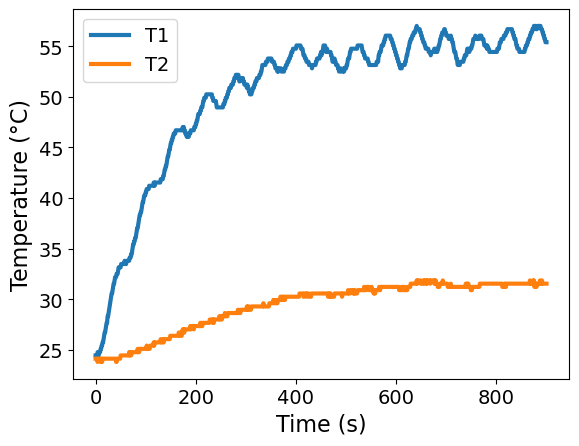

In [3]:
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')

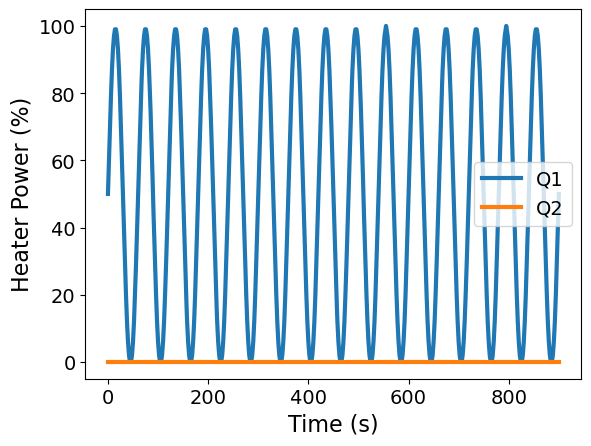

In [4]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

In [5]:
tc_data = TCLabExperiment(
    name="Sine Wave Test for Heater 1",
    time=df['Time'].values,
    T1=df['T1'].values,
    u1=df['Q1'].values,
    P1=200,
    TS1_data=None,
    T2=df['T2'].values,
    u2=df['Q2'].values,
    P2=200,
    TS2_data=None,
    Tamb=df['T1'].values[0],
)

## Analyze FIM with Pyomo.DoE at initial point (sine test)

In [6]:
# Load Pyomo.DoE functions
from pyomo.contrib.doe import (
    ModelOptionLib,
    DesignOfExperiments,
    MeasurementVariables,
    DesignVariables,
)

from pyomo.environ import SolverFactory

# Copied from previous notebook
theta_values = {
    'Ua': 0.05147278733764012,
    'Ub': 0.0005342082856927798,
    'inv_CpH': 0.14622879403418604,
    'inv_CpS': 99.99999754623846,
}

In [7]:
# Get time points for control decisions
t_control = tc_data.time

measurements = MeasurementVariables()
measurements.add_variables(
    'Ts1', # this needs to match the name of the variable in the Pyomo model
    indices={0: t_control}, # specify which time points are measurements
    time_index_position=0) # specify which index is time

print(measurements.variable_names)

['Ts1[0.0]', 'Ts1[1.0]', 'Ts1[2.01]', 'Ts1[3.01]', 'Ts1[4.01]', 'Ts1[5.01]', 'Ts1[6.01]', 'Ts1[7.01]', 'Ts1[8.01]', 'Ts1[9.01]', 'Ts1[10.0]', 'Ts1[11.01]', 'Ts1[12.01]', 'Ts1[13.01]', 'Ts1[14.01]', 'Ts1[15.01]', 'Ts1[16.01]', 'Ts1[17.01]', 'Ts1[18.01]', 'Ts1[19.01]', 'Ts1[20.01]', 'Ts1[21.01]', 'Ts1[22.01]', 'Ts1[23.01]', 'Ts1[24.01]', 'Ts1[25.01]', 'Ts1[26.01]', 'Ts1[27.01]', 'Ts1[28.01]', 'Ts1[29.01]', 'Ts1[30.0]', 'Ts1[31.0]', 'Ts1[32.01]', 'Ts1[33.01]', 'Ts1[34.01]', 'Ts1[35.01]', 'Ts1[36.01]', 'Ts1[37.0]', 'Ts1[38.01]', 'Ts1[39.01]', 'Ts1[40.01]', 'Ts1[41.01]', 'Ts1[42.01]', 'Ts1[43.01]', 'Ts1[44.01]', 'Ts1[45.01]', 'Ts1[46.01]', 'Ts1[47.01]', 'Ts1[48.01]', 'Ts1[49.0]', 'Ts1[50.01]', 'Ts1[51.01]', 'Ts1[52.01]', 'Ts1[53.0]', 'Ts1[54.0]', 'Ts1[55.01]', 'Ts1[56.01]', 'Ts1[57.01]', 'Ts1[58.01]', 'Ts1[59.01]', 'Ts1[60.01]', 'Ts1[61.01]', 'Ts1[62.01]', 'Ts1[63.01]', 'Ts1[64.01]', 'Ts1[65.01]', 'Ts1[66.01]', 'Ts1[67.01]', 'Ts1[68.01]', 'Ts1[69.0]', 'Ts1[70.01]', 'Ts1[71.01]', 'Ts1[72.01]

In [8]:
decisions = DesignVariables()

decisions.add_variables(
    'U1', # this needs to match the name of the variable in the Pyomo model
    indices={0: t_control},
    time_index_position=0,
    lower_bounds=0,
    upper_bounds=100,
    values=tc_data.u1, # these values are used for initialization
)

print(decisions.variable_names)

['U1[0.0]', 'U1[1.0]', 'U1[2.01]', 'U1[3.01]', 'U1[4.01]', 'U1[5.01]', 'U1[6.01]', 'U1[7.01]', 'U1[8.01]', 'U1[9.01]', 'U1[10.0]', 'U1[11.01]', 'U1[12.01]', 'U1[13.01]', 'U1[14.01]', 'U1[15.01]', 'U1[16.01]', 'U1[17.01]', 'U1[18.01]', 'U1[19.01]', 'U1[20.01]', 'U1[21.01]', 'U1[22.01]', 'U1[23.01]', 'U1[24.01]', 'U1[25.01]', 'U1[26.01]', 'U1[27.01]', 'U1[28.01]', 'U1[29.01]', 'U1[30.0]', 'U1[31.0]', 'U1[32.01]', 'U1[33.01]', 'U1[34.01]', 'U1[35.01]', 'U1[36.01]', 'U1[37.0]', 'U1[38.01]', 'U1[39.01]', 'U1[40.01]', 'U1[41.01]', 'U1[42.01]', 'U1[43.01]', 'U1[44.01]', 'U1[45.01]', 'U1[46.01]', 'U1[47.01]', 'U1[48.01]', 'U1[49.0]', 'U1[50.01]', 'U1[51.01]', 'U1[52.01]', 'U1[53.0]', 'U1[54.0]', 'U1[55.01]', 'U1[56.01]', 'U1[57.01]', 'U1[58.01]', 'U1[59.01]', 'U1[60.01]', 'U1[61.01]', 'U1[62.01]', 'U1[63.01]', 'U1[64.01]', 'U1[65.01]', 'U1[66.01]', 'U1[67.01]', 'U1[68.01]', 'U1[69.0]', 'U1[70.01]', 'U1[71.01]', 'U1[72.01]', 'U1[73.0]', 'U1[74.0]', 'U1[75.01]', 'U1[76.01]', 'U1[77.01]', 'U1[78.

In [9]:
def create_model_doe(theta=theta_values):
    ''' Pyomo.DoE needs to be given a function that builds and initializes the model

    Arguments:
        theta: values for the parameters (dictionary). These are used for initialization.
    
    Returns:
        Pyomo model

    This function is simply a wrapper around the `create_model` method defined in tclab_pyomo.py
    Our `create_model` in tclab_pyomo.py has additional inputs we need to specify.
    '''

    return create_model(
        data=tc_data, 
        mode='doe', 
        theta=theta, 
        number_of_states=number_tclab_states
    )

In [10]:
# Create doe_object using DesignOfExperiments
doe_object1 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions,  # design variable
    measurements,  # measurement variable
    create_model_doe,  # model
    solver=SolverFactory('ipopt'),
)

result = doe_object1.compute_FIM(mode='sequential_finite', formula='central')
result.result_analysis()

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [11]:
results_summary(result)

======Results Summary======
Four design criteria log10() value:
A-optimality: 9.698903678283168
D-optimality: 8.292425086814568
E-optimality: -15.256790847776848
Modified E-optimality: 24.939667881782306

FIM:
 [[ 1.88459415e+08 -1.91393890e+08 -8.24201918e+06 -1.04121590e+03]
 [-1.91393890e+08  4.80931030e+09  6.51658566e+07  2.58102008e+04]
 [-8.24201918e+06  6.51658566e+07  1.46673544e+06  3.51179540e+02]
 [-1.04121590e+03  2.58102008e+04  3.51179540e+02  1.38519624e-01]]

eigenvalues:
 [4.81811358e+09 1.80716021e+08 4.06846518e+05 5.53616662e-16]

eigenvectors:
 [[ 4.13259139e-02 -9.98655750e-01  3.12867703e-02 -1.00385955e-13]
 [-9.99053330e-01 -4.17276557e-02 -1.22982147e-02 -5.33299017e-06]
 [-1.35872064e-02  3.07489171e-02  9.99434786e-01 -2.48897568e-06]
 [-5.36175981e-06 -1.45999971e-07  2.42198262e-06  1.00000000e+00]]


We can see the FIM of the sine wave experiment is rank deficient with one eigenvalue that is numerically zero. We wee the corresponding eigenvector points in the direction of the 4th parameter, `inv_CpS`. This means the experiment alone does not contain enough information to uniquely estimate all of the parameters if the model.

Why does it make sense that $C_p^S$ is difficult to estimate?

## Define parameterized sine wave experiment

Can we further optimize the sine wave test to improve the information content? Let's define the parameterized sine wave as:

$$
u(t) = 50 + a \sin(\frac{2 \pi}{60 p} t)
$$

where $a$ is the amplitude (% power), $p$ is the period (minutes), $t$ is the time (seconds), and 60 is a conversion factor (seconds/minute).

Here is code from the `create_model` function defined in `tclab_pyomo.py` to calculate the parameterized control signal from the inputs `sine_amplitude` and `sine_period`:

```
# Calculate parameterized control signal for u1
u1 = 50 + sine_amplitude*np.sin(2*np.pi/(sine_period*60)*time)
```

Here is code from `create_model` in `tclab_pyomo.py` to define the parameterized sine wave in Pyomo.

```
# Add measurement control decision variables
m.u1_period = Var(initialize=sine_period, bounds = (sine_period_min, sine_period_max)) # minutes
m.u1_amplitude = Var(initialize=sine_amplitude) # % power

# Add constraint to calculate u1
m.u1_constraint = Constraint(m.t, rule = lambda m, t: m.U1[t] == 50 + m.u1_amplitude*sin(2*np.pi/(m.u1_period*60)*value(t)))
```

Let's look at the information content of $p = 1$ minute and $a = 50$ %.

Ipopt 3.13.2: halt_on_ampl_error=yes
max_iter=1000
linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

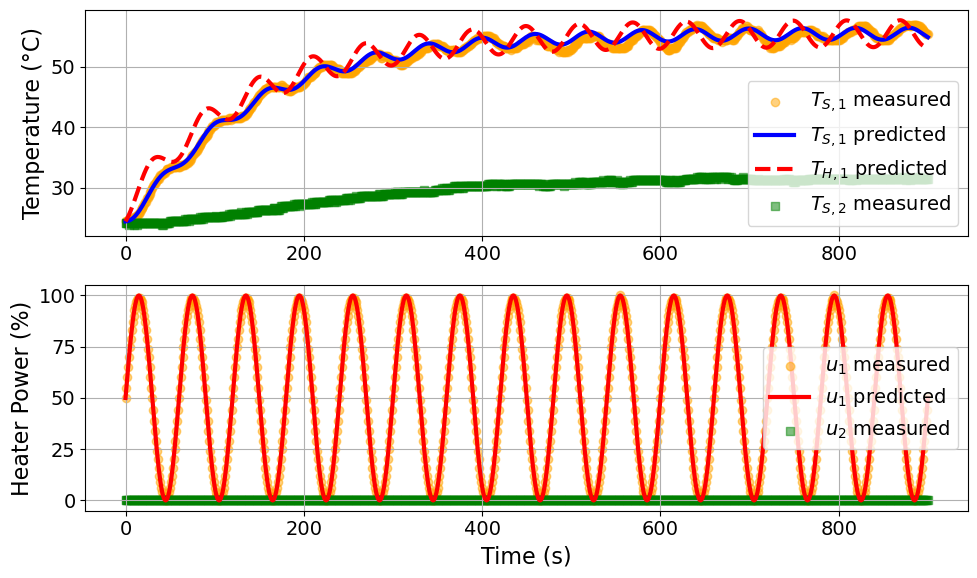

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 1.0 minutes
u1_amplitude = 50 % power
 


In [12]:
def create_model_sens(theta=theta_values):
    '''This function creates a model with the given data and theta values'''
    return create_model(
        data=tc_data,
        mode='doe',
        theta=theta,
        number_of_states=number_tclab_states,
        sine_period=1.0,
        sine_amplitude=50,
    )


# Get time points for control decisions
t_control = tc_data.time

measurements2 = MeasurementVariables()
measurements2.add_variables(
    'Ts1', 
    indices={0: t_control}, 
    time_index_position=0)

decisions2 = DesignVariables()
decisions2.add_variables(
    'u1_period',
    indices=None,
    time_index_position=None,
    lower_bounds=10 / 60,
    upper_bounds=10,
    values=1.0,
)

decisions2.add_variables(
    'u1_amplitude',
    indices=None,
    time_index_position=None,
    lower_bounds=0,
    upper_bounds=50,
    values=50,
)


solver = SolverFactory('ipopt')
# solver.options['bound_push'] = 1E-10
solver.options['halt_on_ampl_error'] = 'yes'
# solver.options['tol'] = 1E-5
# solver.options['acceptable_tol'] = 1E-4
solver.options['max_iter'] = 1000
solver.options['linear_solver'] = 'ma57'

import logging

# Create doe_object using DesignOfExperiments
doe_object2 = DesignOfExperiments(
    theta_values,  # dictionary of parameters
    decisions2,  # design variable
    measurements2,  # measurement variable
    create_model_sens,  # model
    solver=solver,
    logger_level=logging.DEBUG,
)


result = doe_object2.compute_FIM(mode='sequential_finite', formula='central')

result.result_analysis()


pyomo_doe_results = extract_plot_results(tc_data, doe_object2.model)

In [13]:
results_summary(result)

======Results Summary======
Four design criteria log10() value:
A-optimality: 9.705521668583394
D-optimality: nan
E-optimality: nan
Modified E-optimality: nan

FIM:
 [[ 1.92187689e+08 -1.95158832e+08 -8.40569881e+06 -1.06170169e+03]
 [-1.95158832e+08  4.88231745e+09  6.63743245e+07  2.62025550e+04]
 [-8.40569881e+06  6.63743245e+07  1.49550678e+06  3.57695899e+02]
 [-1.06170169e+03  2.62025550e+04  3.57695899e+02  1.40628265e-01]]

eigenvalues:
 [ 4.89133300e+09  1.84254423e+08  4.13222899e+05 -3.59981640e-16]

eigenvectors:
 [[ 4.15154255e-02 -9.98649054e-01  3.12495844e-02 -1.00990095e-13]
 [-9.99044858e-01 -4.19179925e-02 -1.23390827e-02 -5.33299017e-06]
 [-1.36323331e-02  3.07074744e-02  9.99435446e-01 -2.48897568e-06]
 [-5.36182695e-06 -1.47118186e-07  2.42176631e-06  1.00000000e+00]]


/Users/adowling/DowlingLab/Teaching/pyomo-doe/notebooks/tclab_pyomo.py:776: RuntimeWarning: invalid value encountered in log10
  print("D-optimality:", np.log10(result.det))
/Users/adowling/DowlingLab/Teaching/pyomo-doe/notebooks/tclab_pyomo.py:777: RuntimeWarning: invalid value encountered in log10
  print("E-optimality:", np.log10(result.min_eig))
/Users/adowling/DowlingLab/Teaching/pyomo-doe/notebooks/tclab_pyomo.py:778: RuntimeWarning: invalid value encountered in log10
  print("Modified E-optimality:", np.log10(result.cond))


This parameterization reproduced the original sine wave experiment. As expected, the FIM is still rank deficient.

## Perform sensitivity analysis to sine wave frequency and period

Now let's perform a sensitivity analysis over $p$ and $a$. `Pyomo.DoE` includes functions to automate this analysis including visualization. In our experience, an exploratory analysis like this is especially helpful to develop intuition about the physical system and model.

In [14]:
# Design variable ranges as lists

quick_run = False

if not quick_run:
    # Larger sensitivity analysis with more detailed plots
    design_ranges = {
        "u1_period": [1, 2, 3, 4, 5, 6, 7, 8],
        "u1_amplitude": [15, 25, 35, 45],
    }

else:
    # Faster sensitivity analysis, good for debugging
    design_ranges = {"u1_period": [1, 2], "u1_amplitude": [20, 50]}

# Choose from 'sequential_finite', 'direct_kaug'
# sensi_opt = "sequential_finite"
sensi_opt = "direct_kaug"

INFO: =======Iteration Number: 1 =====
DEBUG: Design variable values of this iteration: {'u1_period': 1,
'u1_amplitude': 15}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.1 seconds
INFO: This is run 1 out of 32.
INFO: The code has run  1.12 seconds.
INFO: Estimated remaining time:  34.63 seconds


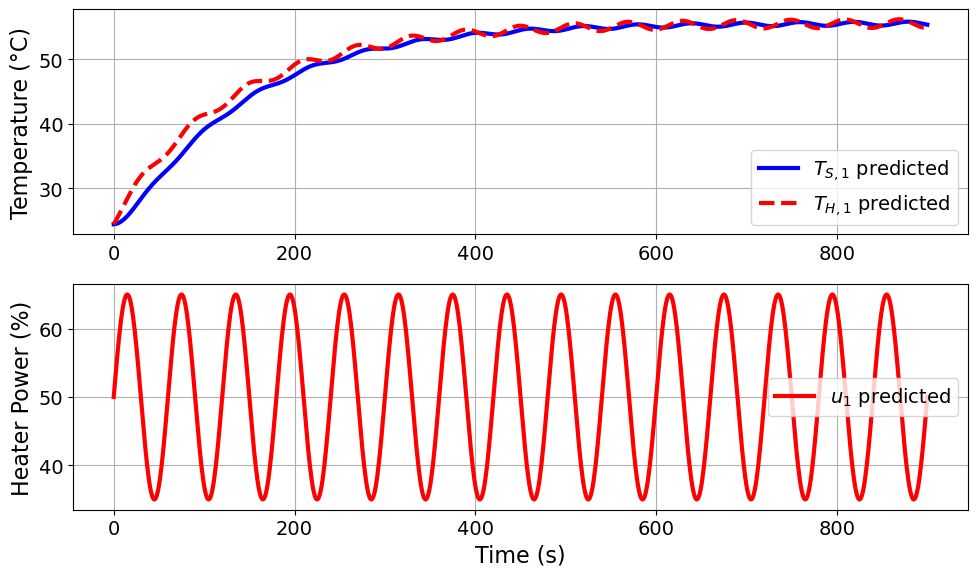

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 1 minutes
u1_amplitude = 15 % power
 
INFO: =======Iteration Number: 2 =====
DEBUG: Design variable values of this iteration: {'u1_period': 1,
'u1_amplitude': 25}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 0.9 seconds
INFO: This is run 2 out of 32.
INFO: The code has run  2.05 seconds.
INFO: Estimated remaining time:  30.78 seconds


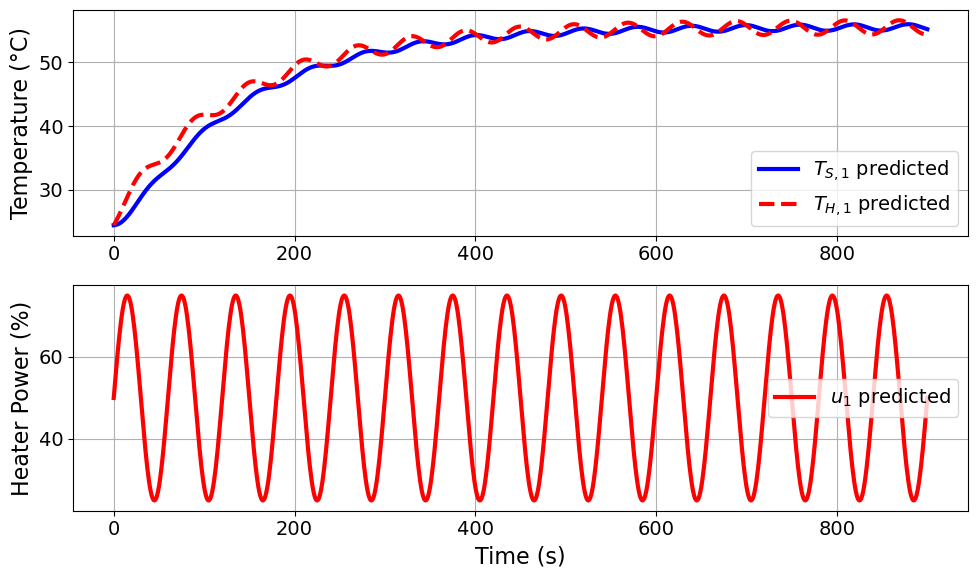

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 1 minutes
u1_amplitude = 25 % power
 
INFO: =======Iteration Number: 3 =====
DEBUG: Design variable values of this iteration: {'u1_period': 1,
'u1_amplitude': 35}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 0.9 seconds
INFO: This is run 3 out of 32.
INFO: The code has run  2.99 seconds.
INFO: Estimated remaining time:  28.87 seconds


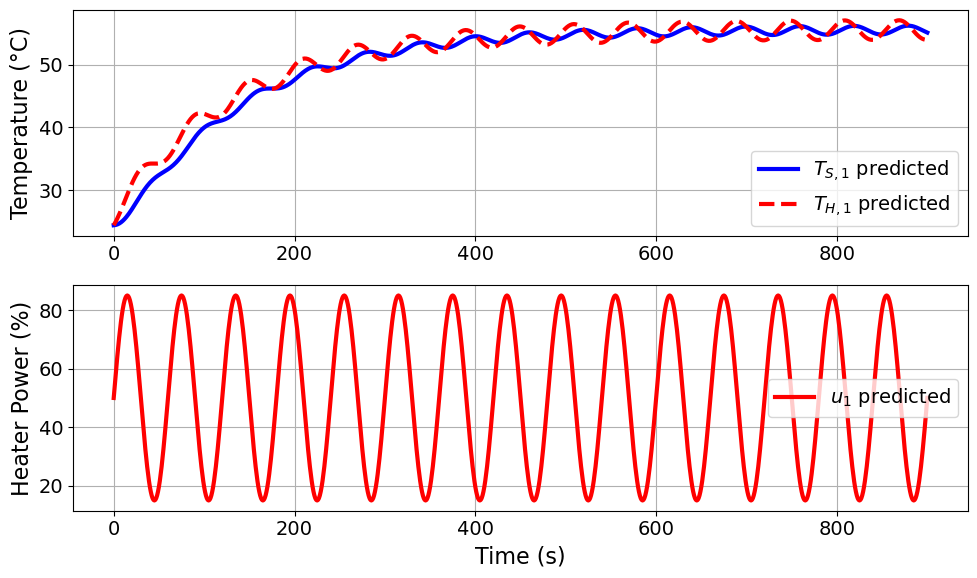

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 1 minutes
u1_amplitude = 35 % power
 
INFO: =======Iteration Number: 4 =====
DEBUG: Design variable values of this iteration: {'u1_period': 1,
'u1_amplitude': 45}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.2 seconds
INFO: This is run 4 out of 32.
INFO: The code has run  4.21 seconds.
INFO: Estimated remaining time:  29.48 seconds


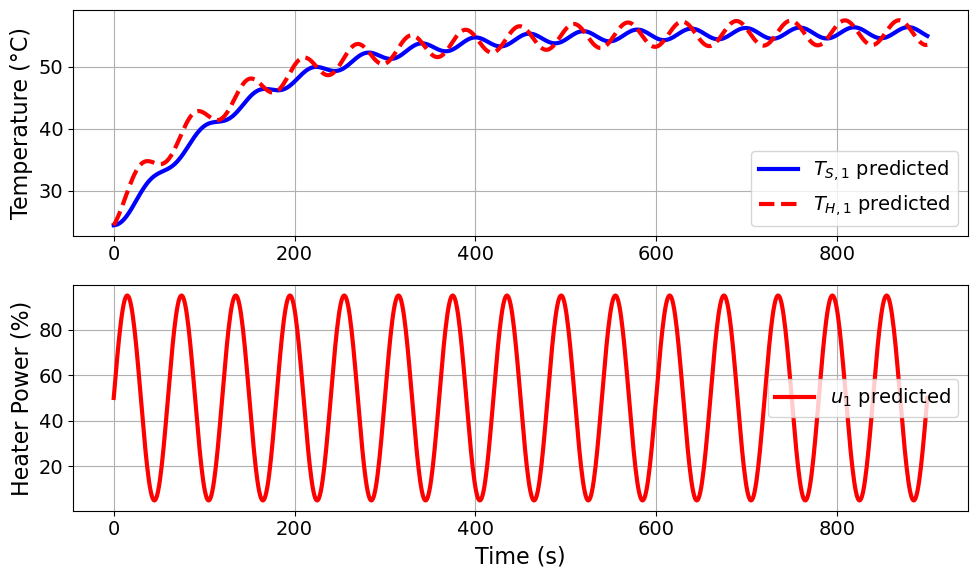

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 1 minutes
u1_amplitude = 45 % power
 
INFO: =======Iteration Number: 5 =====
DEBUG: Design variable values of this iteration: {'u1_period': 2,
'u1_amplitude': 15}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 0.9 seconds
INFO: This is run 5 out of 32.
INFO: The code has run  5.15 seconds.
INFO: Estimated remaining time:  27.81 seconds


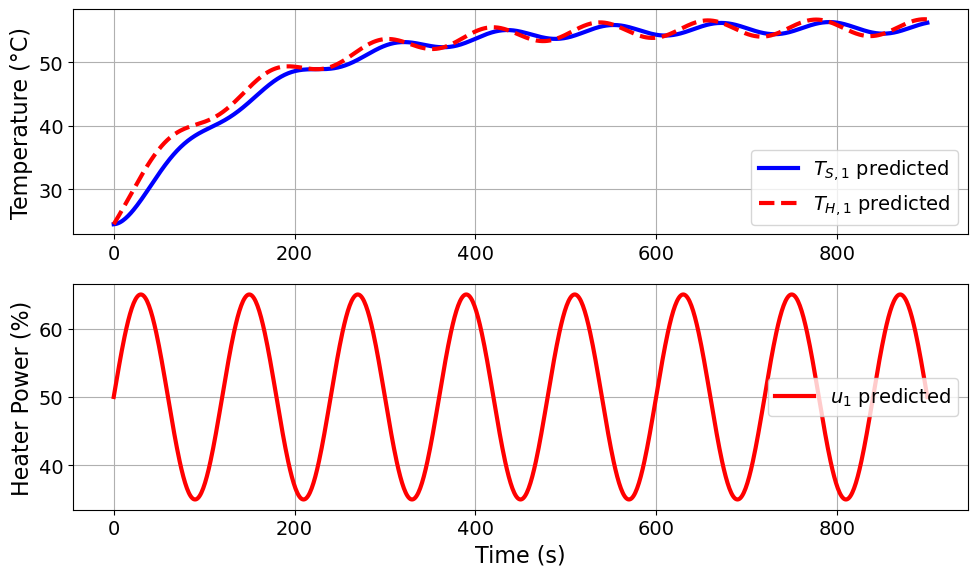

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 2 minutes
u1_amplitude = 15 % power
 
INFO: =======Iteration Number: 6 =====
DEBUG: Design variable values of this iteration: {'u1_period': 2,
'u1_amplitude': 25}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.2 seconds
INFO: This is run 6 out of 32.
INFO: The code has run  6.36 seconds.
INFO: Estimated remaining time:  27.57 seconds


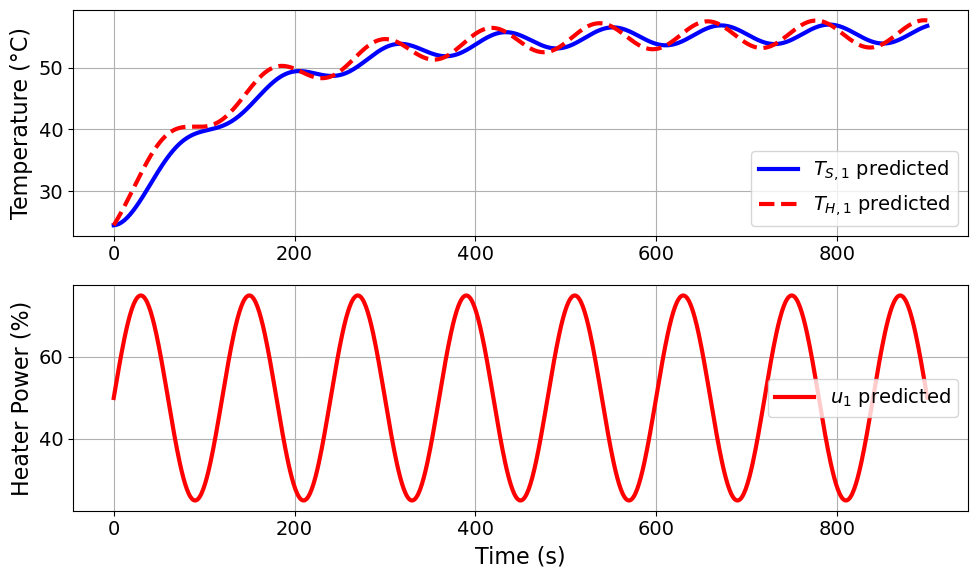

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 2 minutes
u1_amplitude = 25 % power
 
INFO: =======Iteration Number: 7 =====
DEBUG: Design variable values of this iteration: {'u1_period': 2,
'u1_amplitude': 35}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.0 seconds
INFO: This is run 7 out of 32.
INFO: The code has run  7.32 seconds.
INFO: Estimated remaining time:  26.13 seconds


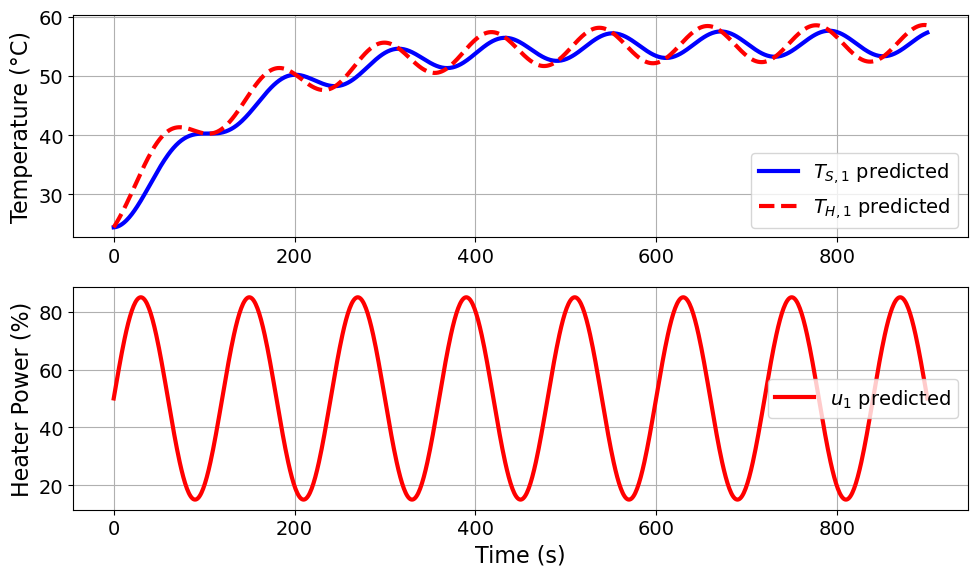

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 2 minutes
u1_amplitude = 35 % power
 
INFO: =======Iteration Number: 8 =====
DEBUG: Design variable values of this iteration: {'u1_period': 2,
'u1_amplitude': 45}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 0.9 seconds
INFO: This is run 8 out of 32.
INFO: The code has run  8.25 seconds.
INFO: Estimated remaining time:  24.76 seconds


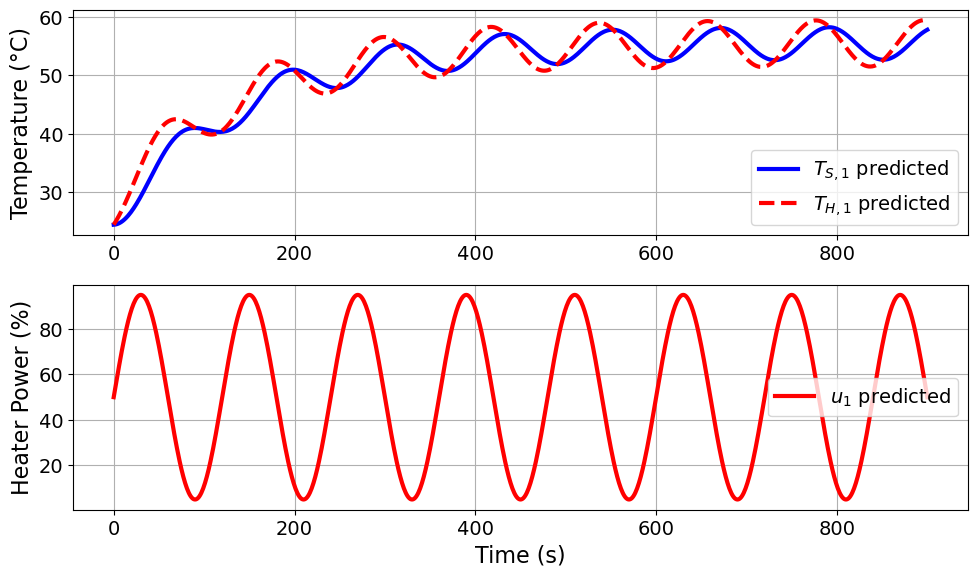

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 2 minutes
u1_amplitude = 45 % power
 
INFO: =======Iteration Number: 9 =====
DEBUG: Design variable values of this iteration: {'u1_period': 3,
'u1_amplitude': 15}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.3 seconds
INFO: This is run 9 out of 32.
INFO: The code has run  9.52 seconds.
INFO: Estimated remaining time:  24.33 seconds


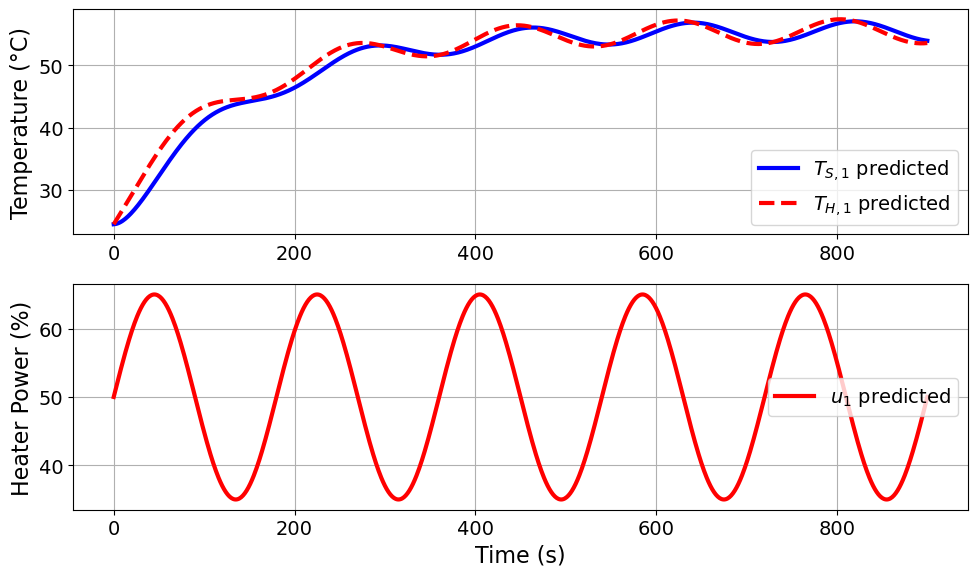

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 3 minutes
u1_amplitude = 15 % power
 
INFO: =======Iteration Number: 10 =====
DEBUG: Design variable values of this iteration: {'u1_period': 3,
'u1_amplitude': 25}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 0.9 seconds
INFO: This is run 10 out of 32.
INFO: The code has run  10.47 seconds.
INFO: Estimated remaining time:  23.02 seconds


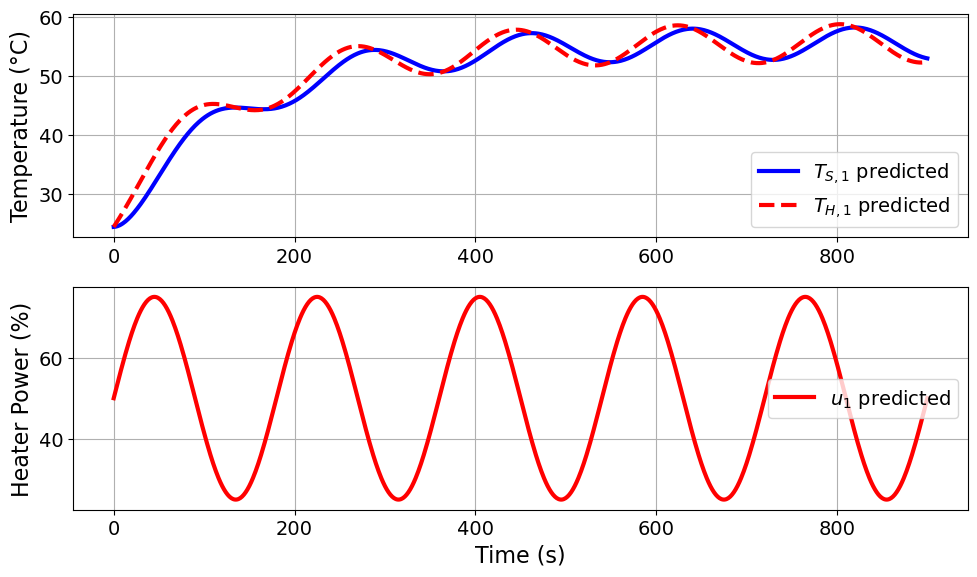

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 3 minutes
u1_amplitude = 25 % power
 
INFO: =======Iteration Number: 11 =====
DEBUG: Design variable values of this iteration: {'u1_period': 3,
'u1_amplitude': 35}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.2 seconds
INFO: This is run 11 out of 32.
INFO: The code has run  11.68 seconds.
INFO: Estimated remaining time:  22.3 seconds


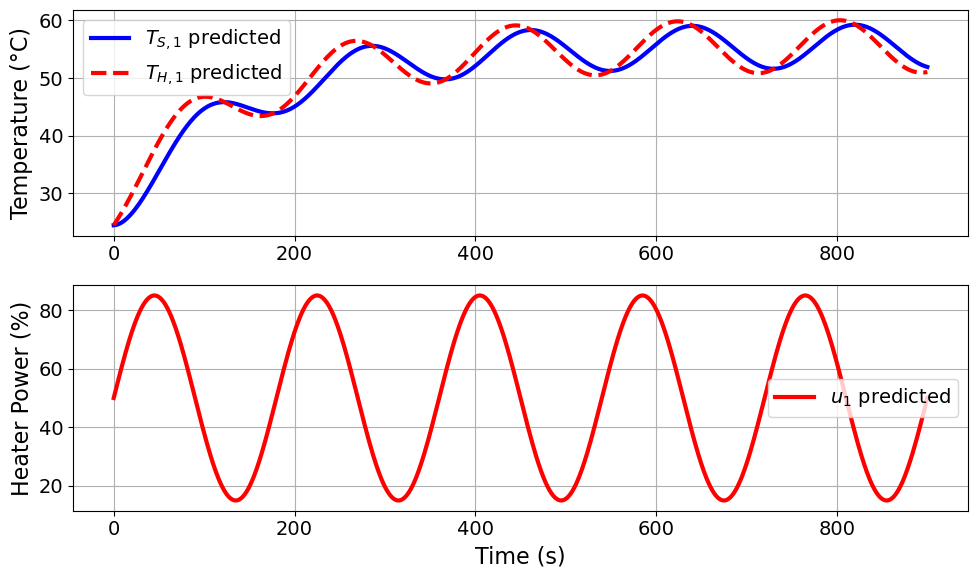

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 3 minutes
u1_amplitude = 35 % power
 
INFO: =======Iteration Number: 12 =====
DEBUG: Design variable values of this iteration: {'u1_period': 3,
'u1_amplitude': 45}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.0 seconds
INFO: This is run 12 out of 32.
INFO: The code has run  12.64 seconds.
INFO: Estimated remaining time:  21.07 seconds


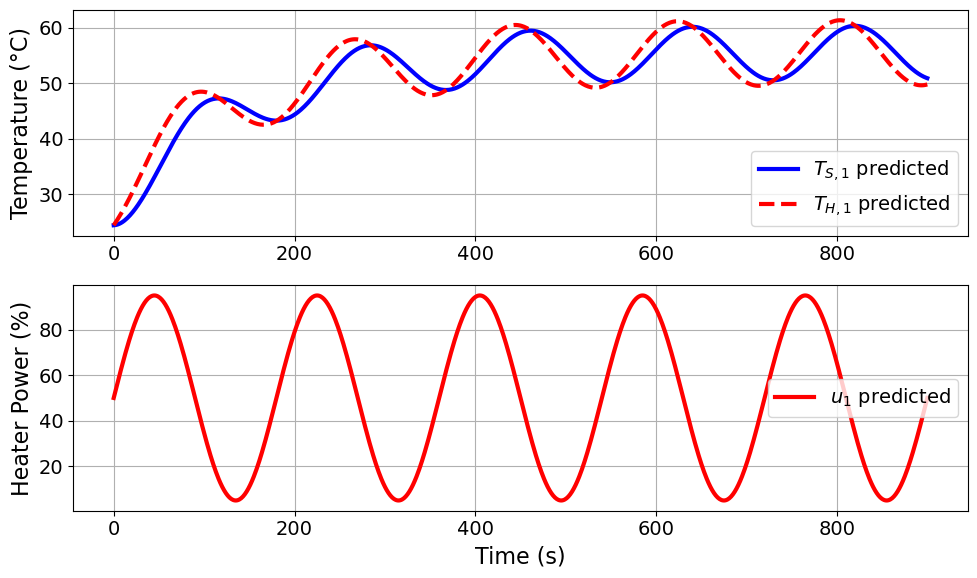

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 3 minutes
u1_amplitude = 45 % power
 
INFO: =======Iteration Number: 13 =====
DEBUG: Design variable values of this iteration: {'u1_period': 4,
'u1_amplitude': 15}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.0 seconds
INFO: This is run 13 out of 32.
INFO: The code has run  13.6 seconds.
INFO: Estimated remaining time:  19.88 seconds


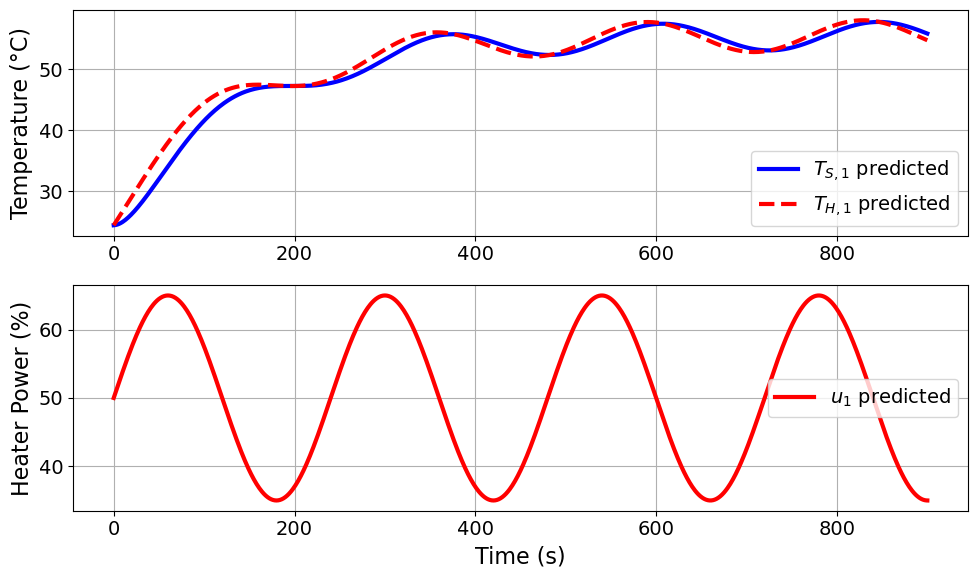

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 4 minutes
u1_amplitude = 15 % power
 
INFO: =======Iteration Number: 14 =====
DEBUG: Design variable values of this iteration: {'u1_period': 4,
'u1_amplitude': 25}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.5 seconds
INFO: This is run 14 out of 32.
INFO: The code has run  15.06 seconds.
INFO: Estimated remaining time:  19.36 seconds


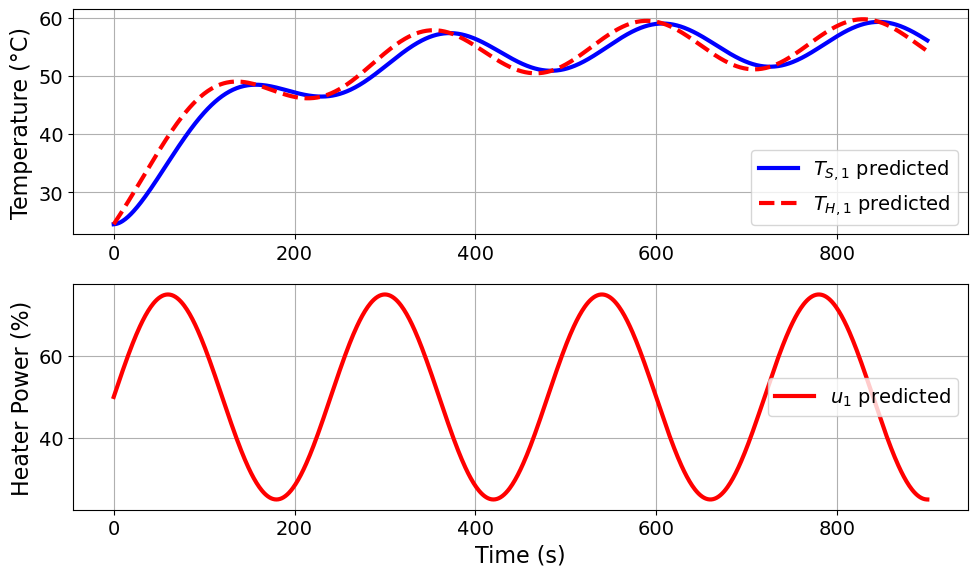

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 4 minutes
u1_amplitude = 25 % power
 
INFO: =======Iteration Number: 15 =====
DEBUG: Design variable values of this iteration: {'u1_period': 4,
'u1_amplitude': 35}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.0 seconds
INFO: This is run 15 out of 32.
INFO: The code has run  16.02 seconds.
INFO: Estimated remaining time:  18.16 seconds


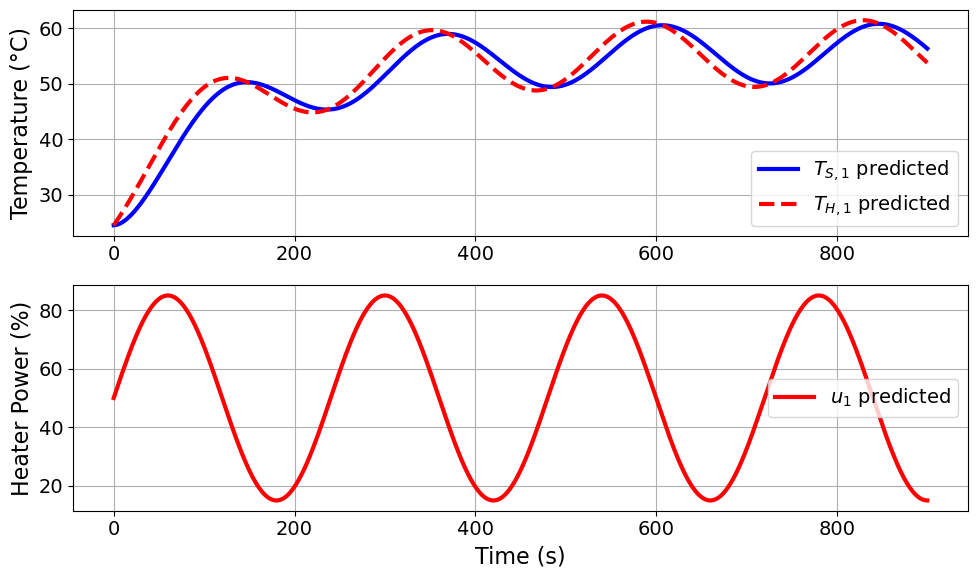

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 4 minutes
u1_amplitude = 35 % power
 
INFO: =======Iteration Number: 16 =====
DEBUG: Design variable values of this iteration: {'u1_period': 4,
'u1_amplitude': 45}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.2 seconds
INFO: This is run 16 out of 32.
INFO: The code has run  17.2 seconds.
INFO: Estimated remaining time:  17.2 seconds


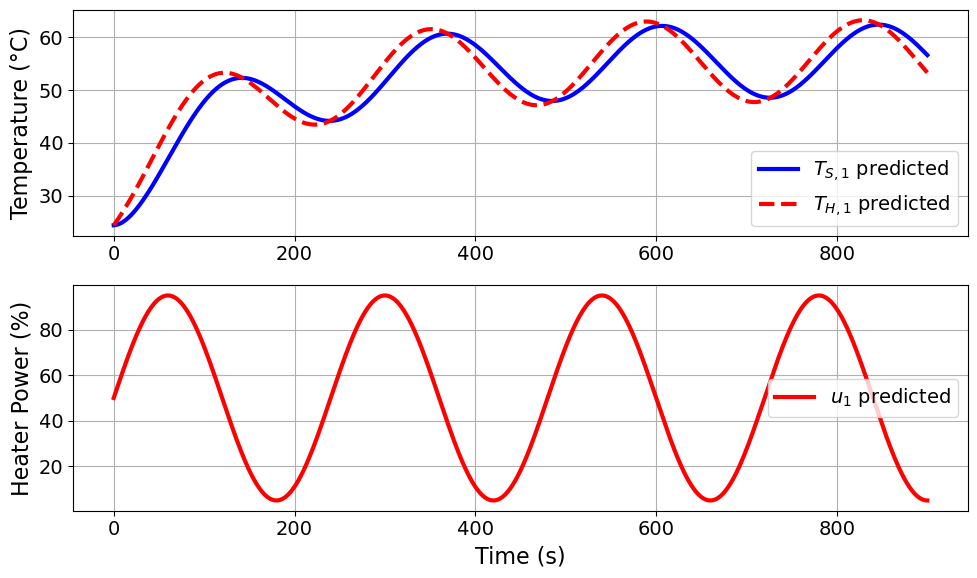

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 4 minutes
u1_amplitude = 45 % power
 
INFO: =======Iteration Number: 17 =====
DEBUG: Design variable values of this iteration: {'u1_period': 5,
'u1_amplitude': 15}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 0.9 seconds
INFO: This is run 17 out of 32.
INFO: The code has run  18.15 seconds.
INFO: Estimated remaining time:  16.01 seconds


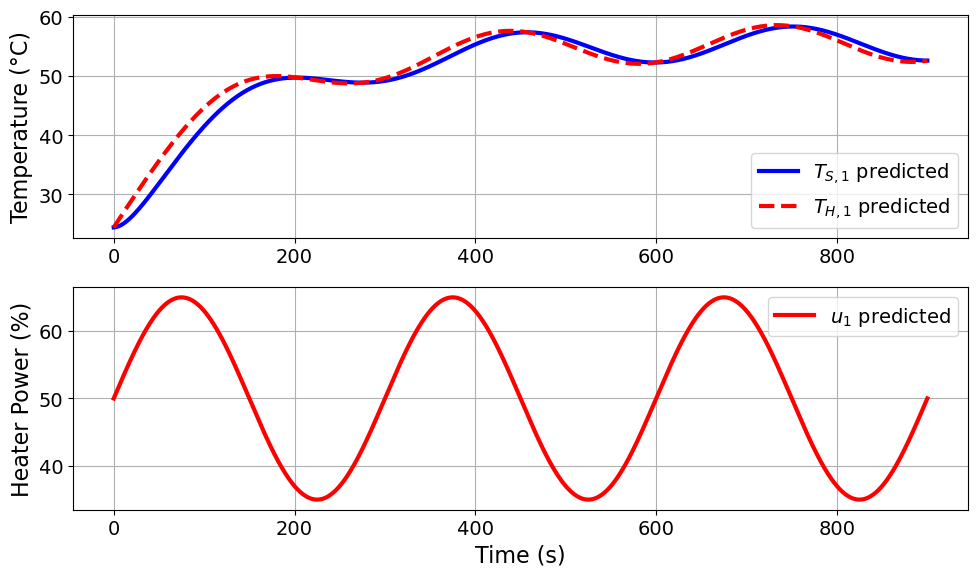

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 5 minutes
u1_amplitude = 15 % power
 
INFO: =======Iteration Number: 18 =====
DEBUG: Design variable values of this iteration: {'u1_period': 5,
'u1_amplitude': 25}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 0.9 seconds
INFO: This is run 18 out of 32.
INFO: The code has run  19.08 seconds.
INFO: Estimated remaining time:  14.84 seconds


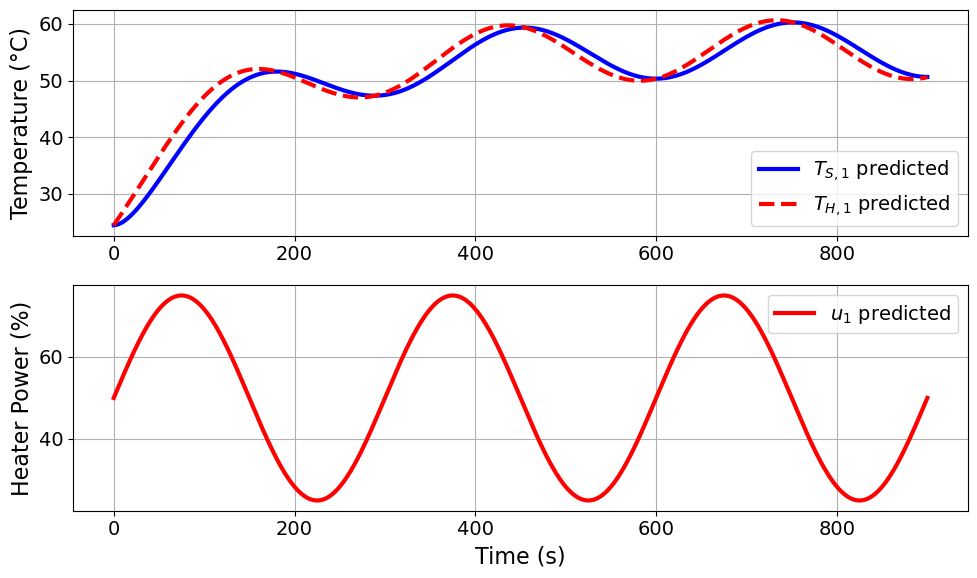

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 5 minutes
u1_amplitude = 25 % power
 
INFO: =======Iteration Number: 19 =====
DEBUG: Design variable values of this iteration: {'u1_period': 5,
'u1_amplitude': 35}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.2 seconds
INFO: This is run 19 out of 32.
INFO: The code has run  20.31 seconds.
INFO: Estimated remaining time:  13.89 seconds


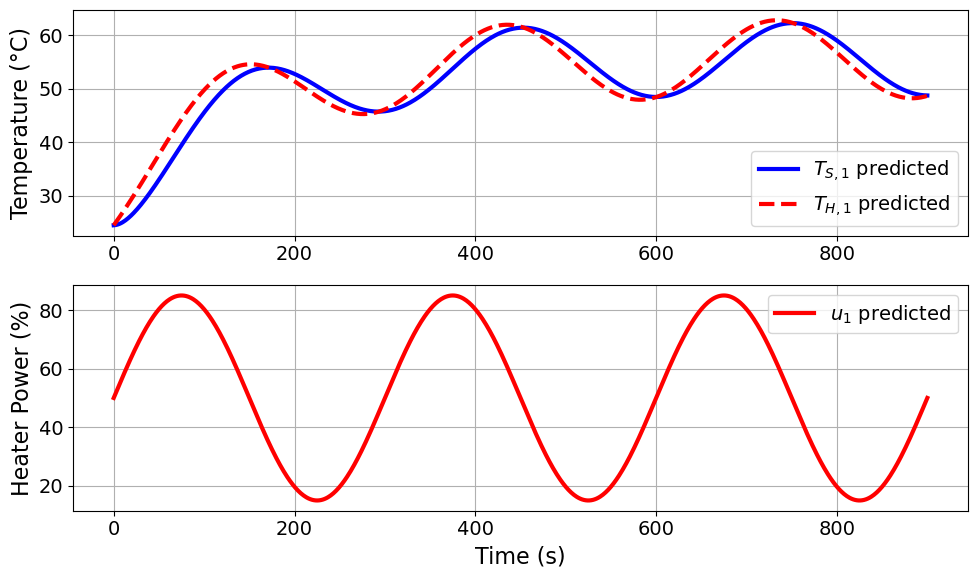

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 5 minutes
u1_amplitude = 35 % power
 
INFO: =======Iteration Number: 20 =====
DEBUG: Design variable values of this iteration: {'u1_period': 5,
'u1_amplitude': 45}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.0 seconds
INFO: This is run 20 out of 32.
INFO: The code has run  21.28 seconds.
INFO: Estimated remaining time:  12.77 seconds


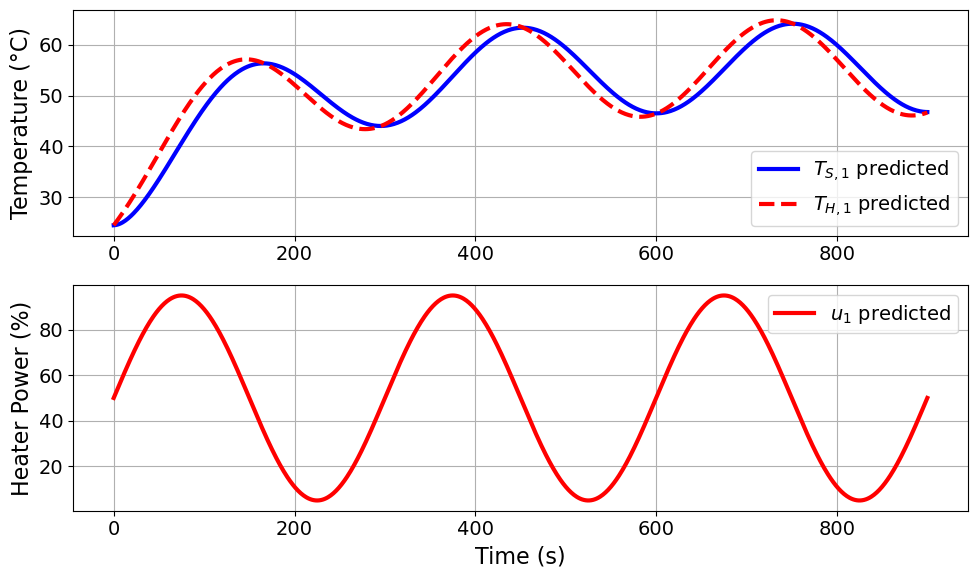

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 5 minutes
u1_amplitude = 45 % power
 
INFO: =======Iteration Number: 21 =====
DEBUG: Design variable values of this iteration: {'u1_period': 6,
'u1_amplitude': 15}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.3 seconds
INFO: This is run 21 out of 32.
INFO: The code has run  22.58 seconds.
INFO: Estimated remaining time:  11.83 seconds


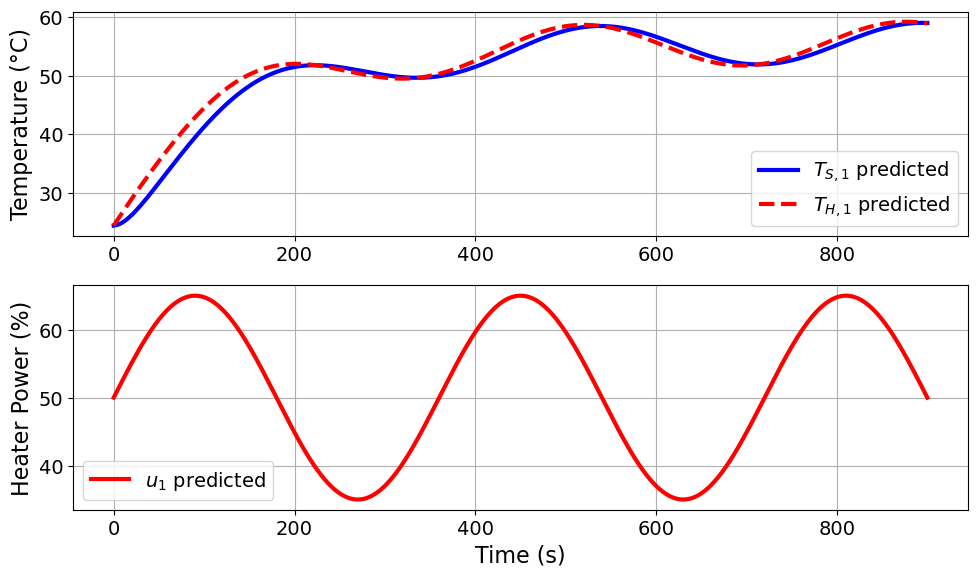

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 6 minutes
u1_amplitude = 15 % power
 
INFO: =======Iteration Number: 22 =====
DEBUG: Design variable values of this iteration: {'u1_period': 6,
'u1_amplitude': 25}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.0 seconds
INFO: This is run 22 out of 32.
INFO: The code has run  23.54 seconds.
INFO: Estimated remaining time:  10.7 seconds


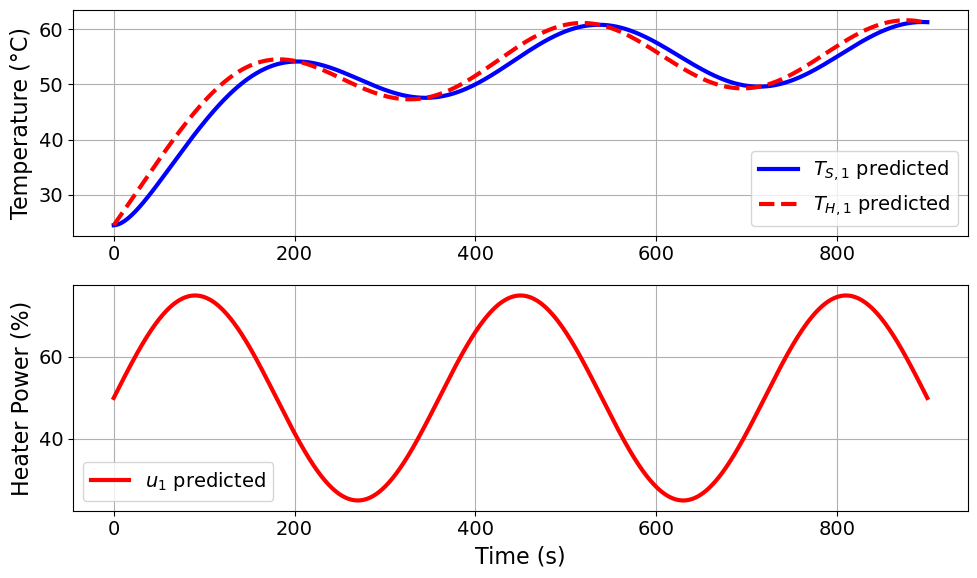

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 6 minutes
u1_amplitude = 25 % power
 
INFO: =======Iteration Number: 23 =====
DEBUG: Design variable values of this iteration: {'u1_period': 6,
'u1_amplitude': 35}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 0.9 seconds
INFO: This is run 23 out of 32.
INFO: The code has run  24.5 seconds.
INFO: Estimated remaining time:  9.59 seconds


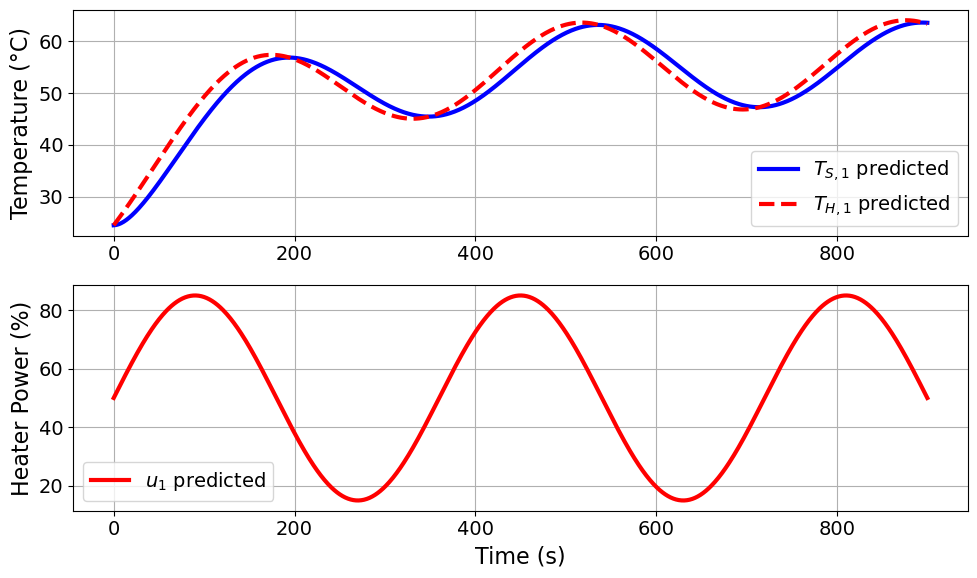

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 6 minutes
u1_amplitude = 35 % power
 
INFO: =======Iteration Number: 24 =====
DEBUG: Design variable values of this iteration: {'u1_period': 6,
'u1_amplitude': 45}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.3 seconds
INFO: This is run 24 out of 32.
INFO: The code has run  25.76 seconds.
INFO: Estimated remaining time:  8.59 seconds


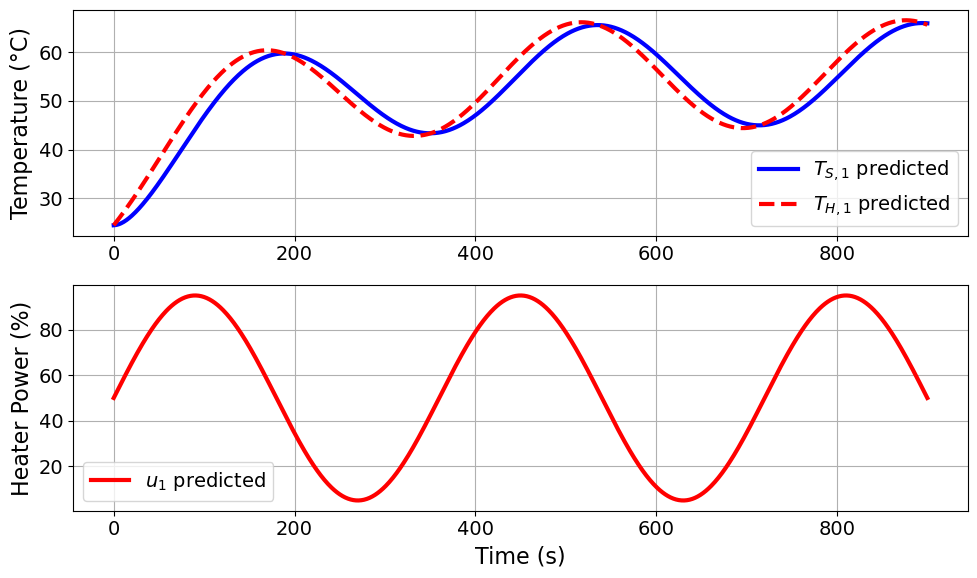

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 6 minutes
u1_amplitude = 45 % power
 
INFO: =======Iteration Number: 25 =====
DEBUG: Design variable values of this iteration: {'u1_period': 7,
'u1_amplitude': 15}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.0 seconds
INFO: This is run 25 out of 32.
INFO: The code has run  26.73 seconds.
INFO: Estimated remaining time:  7.49 seconds


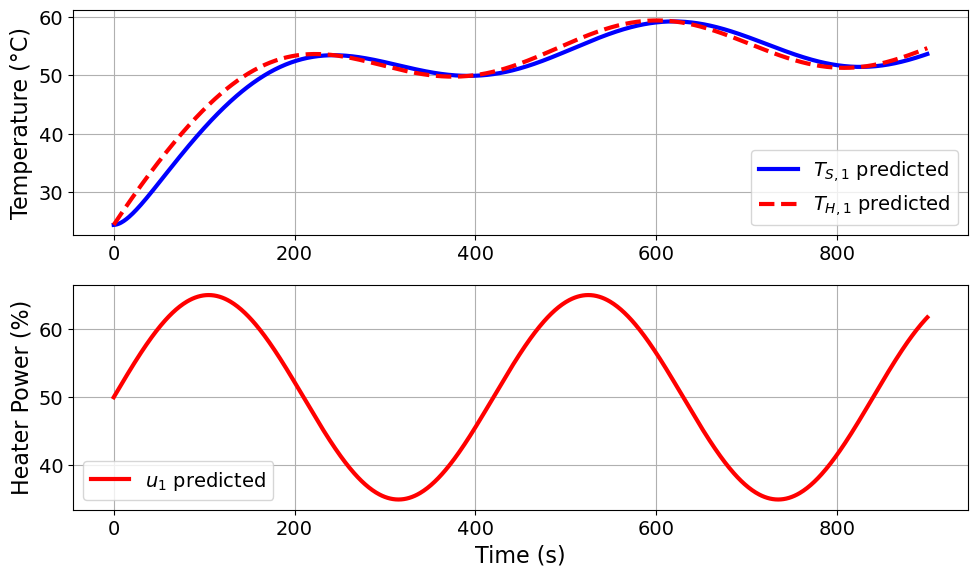

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 7 minutes
u1_amplitude = 15 % power
 
INFO: =======Iteration Number: 26 =====
DEBUG: Design variable values of this iteration: {'u1_period': 7,
'u1_amplitude': 25}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.2 seconds
INFO: This is run 26 out of 32.
INFO: The code has run  27.97 seconds.
INFO: Estimated remaining time:  6.45 seconds


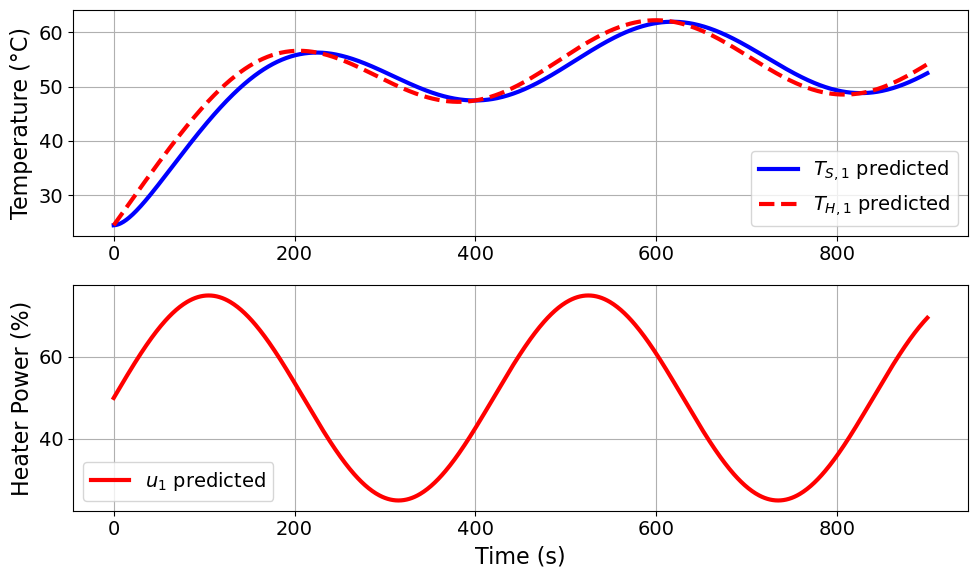

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 7 minutes
u1_amplitude = 25 % power
 
INFO: =======Iteration Number: 27 =====
DEBUG: Design variable values of this iteration: {'u1_period': 7,
'u1_amplitude': 35}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.0 seconds
INFO: This is run 27 out of 32.
INFO: The code has run  28.93 seconds.
INFO: Estimated remaining time:  5.36 seconds


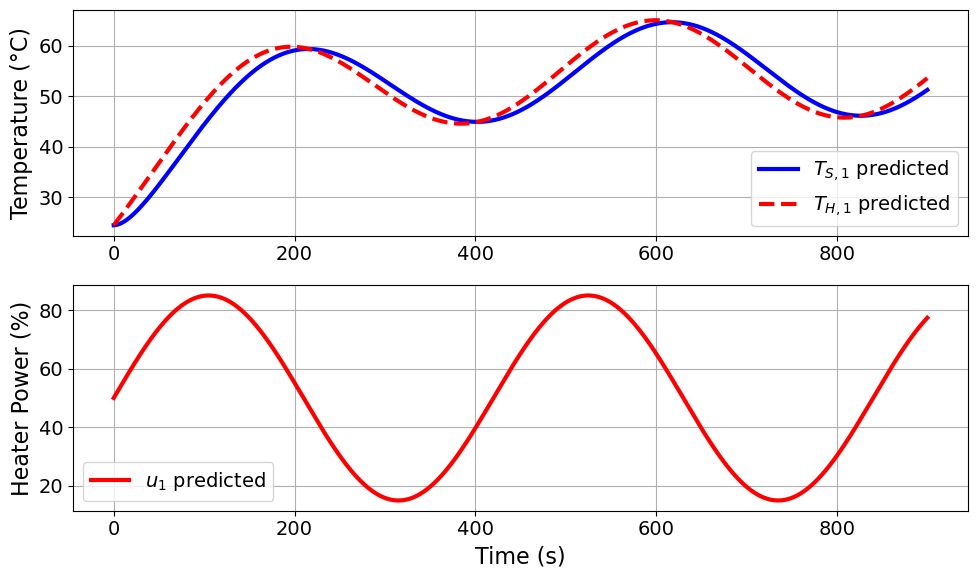

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 7 minutes
u1_amplitude = 35 % power
 
INFO: =======Iteration Number: 28 =====
DEBUG: Design variable values of this iteration: {'u1_period': 7,
'u1_amplitude': 45}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.0 seconds
INFO: This is run 28 out of 32.
INFO: The code has run  29.92 seconds.
INFO: Estimated remaining time:  4.27 seconds


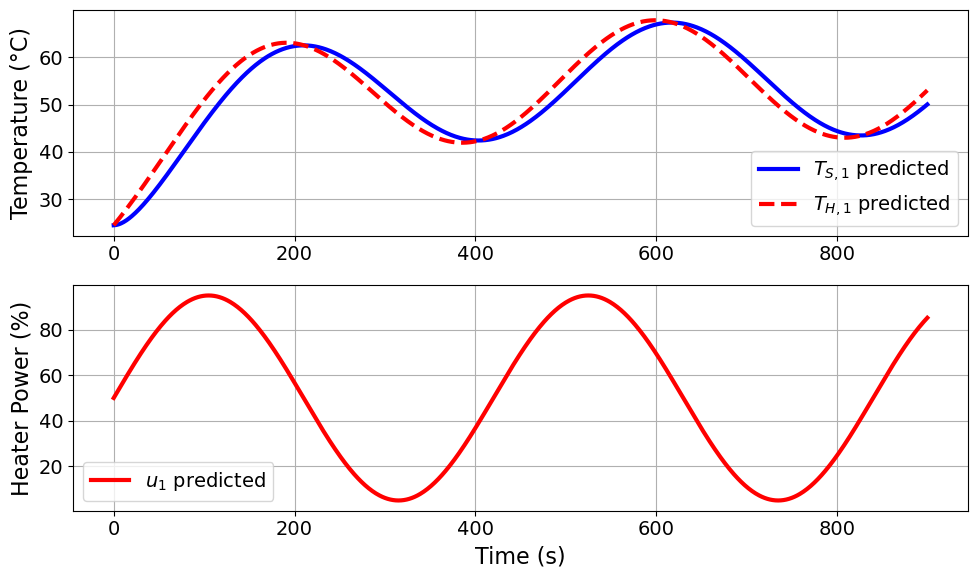

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 7 minutes
u1_amplitude = 45 % power
 
INFO: =======Iteration Number: 29 =====
DEBUG: Design variable values of this iteration: {'u1_period': 8,
'u1_amplitude': 15}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.3 seconds
INFO: This is run 29 out of 32.
INFO: The code has run  31.2 seconds.
INFO: Estimated remaining time:  3.23 seconds


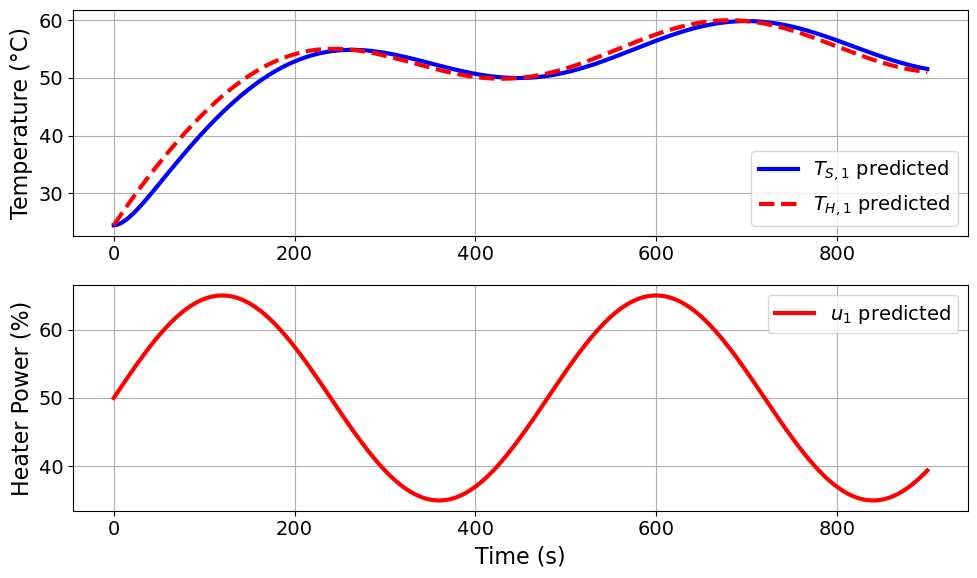

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 8 minutes
u1_amplitude = 15 % power
 
INFO: =======Iteration Number: 30 =====
DEBUG: Design variable values of this iteration: {'u1_period': 8,
'u1_amplitude': 25}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.0 seconds
INFO: This is run 30 out of 32.
INFO: The code has run  32.17 seconds.
INFO: Estimated remaining time:  2.14 seconds


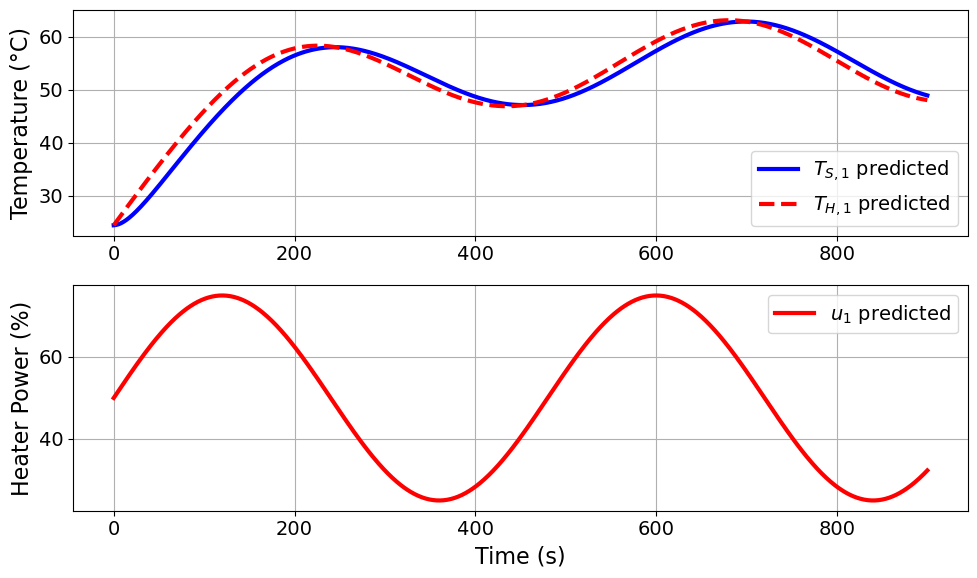

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 8 minutes
u1_amplitude = 25 % power
 
INFO: =======Iteration Number: 31 =====
DEBUG: Design variable values of this iteration: {'u1_period': 8,
'u1_amplitude': 35}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.2 seconds
INFO: This is run 31 out of 32.
INFO: The code has run  33.42 seconds.
INFO: Estimated remaining time:  1.08 seconds


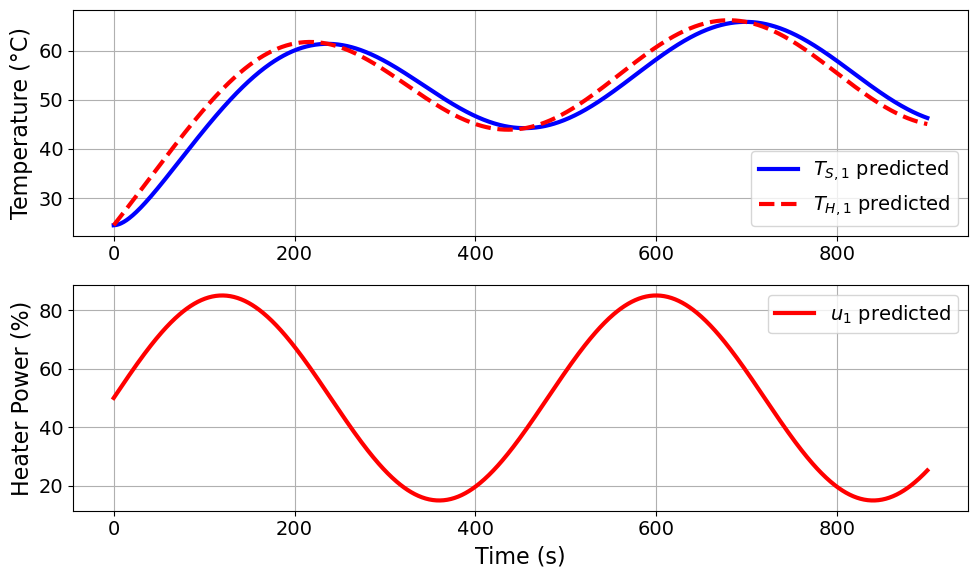

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 8 minutes
u1_amplitude = 35 % power
 
INFO: =======Iteration Number: 32 =====
DEBUG: Design variable values of this iteration: {'u1_period': 8,
'u1_amplitude': 45}
DEBUG: The variable is fixed:  Ts1[0.0]
INFO: elapsed time: 1.0 seconds
INFO: This is run 32 out of 32.
INFO: The code has run  34.38 seconds.
INFO: Estimated remaining time:  0.0 seconds


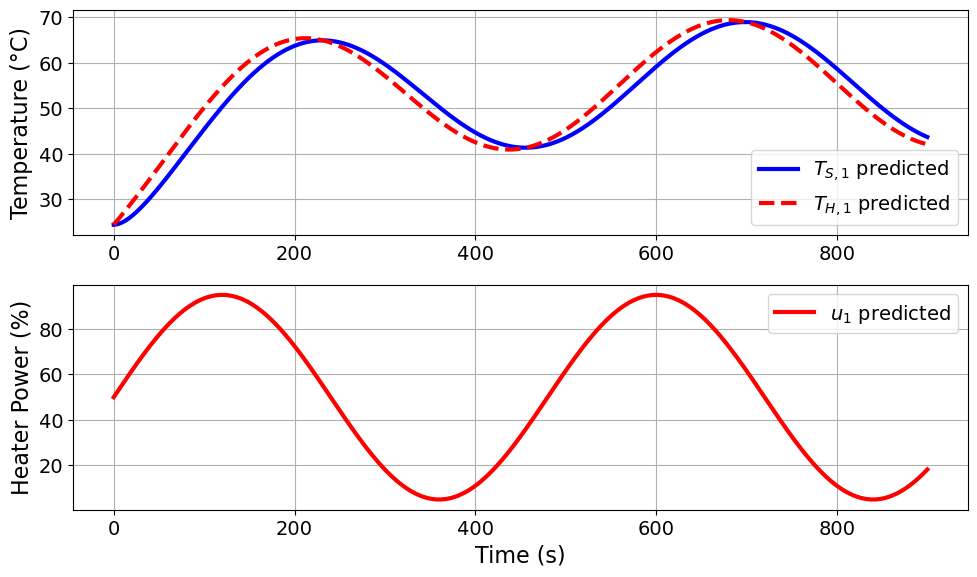

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
u1_period = 8 minutes
u1_amplitude = 45 % power
 
INFO: Overall wall clock time [s]:  34.38077020907076


In [15]:
plot_each_iteration = lambda mod: extract_plot_results(None, mod)

# Grid search
all_fim = doe_object2.run_grid_search(
    design_ranges,  # range of design variables
    mode=sensi_opt,  # solver option for sensitivity
    post_processing_function=plot_each_iteration,
)

## Visualize and interpret sensitivity analysis results

/Users/adowling/DowlingLab/dev/pyomo/pyomo/contrib/doe/result.py:663: RuntimeWarning: invalid value encountered in log10
  hes_e = np.log10(self.cri_e)
/Users/adowling/DowlingLab/dev/pyomo/pyomo/contrib/doe/result.py:664: RuntimeWarning: invalid value encountered in log10
  hes_d = np.log10(self.cri_d)
/Users/adowling/DowlingLab/dev/pyomo/pyomo/contrib/doe/result.py:665: RuntimeWarning: invalid value encountered in log10
  hes_e2 = np.log10(self.cri_e_cond)


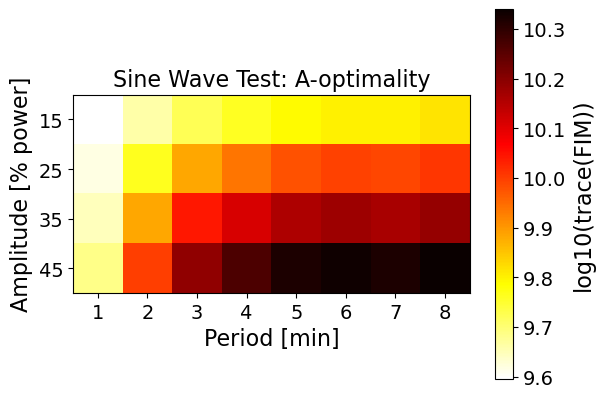

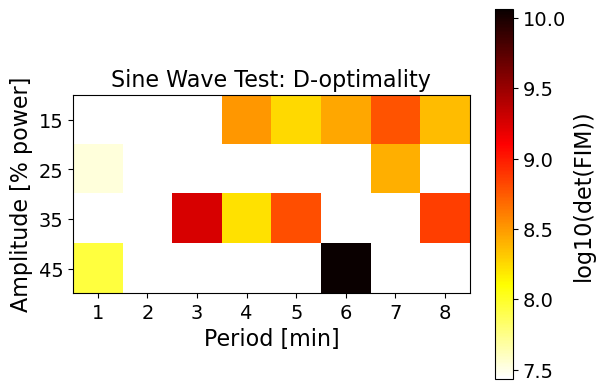

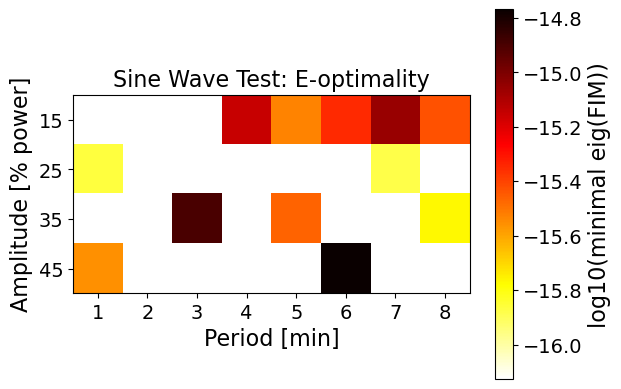

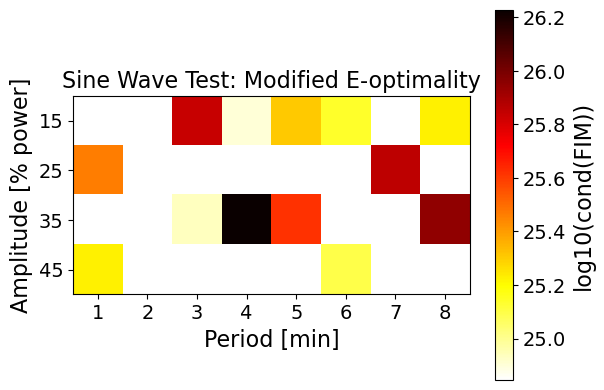

In [16]:
# Extract criteria from FIM
all_fim.extract_criteria()

# Make heat maps
all_fim.figure_drawing(
    {},  # Empty dictionary because the sensitivity analysis only included 2 dimensions.
    ["u1_period", "u1_amplitude"],
    "Sine Wave Test",
    "Period [min]",
    "Amplitude [% power]",
)

These heatmaps tell us a lot about the mathematical model for the TCLab system.

A-optimality (trace of FIM) is the largest with a long period (8 minutes) and large amplitude (45%). Why does this make sense? The long period means the heating and cooling is more gradual. This gives more information about the dynamics of the system, especially the lag in heat transfer between the two modeled thermal masses. Likewise, the larger amplitude ensures a larger temperature range is explored, which maximizes the ratio of the signal to noise (which is assumed to be i.i.d.)

The D-, E-, and modified-E optimality results are more nuanced. We see a random pattern of white and colors. The white corresponds to `nan` results from taking the log of a negative number. Recall for this system, the smallest eigenvalue is numerically near zero. These results tell us that even optimizing the period and amplitude is not enough to reliably estimate $C_p^S$. We need either multiple experiments or a different experiment design.